# <center>Bike Sharing Demand</center>

### <div align='right'>Filip Kowalski</right>

In [25]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
# set figure size
plt.rcParams['figure.figsize'] = (10,10)

# Load Data

In [14]:
filename='train.csv'
# names=['sepal-length','sepal-width','petal-length','petal-width','class']
dataset=read_csv(filename)

# Looking on data 

In [15]:
dataset.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


### Data Fields
<br>
**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
<br>
**holiday** - whether the day is considered a holidayr
<br>
**workingday** - whether the day is neither a weekend nor holiday
<br>
**weather**
1. : Clear, Few clouds, Partly cloudy, Partly cloudy 
* : Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
* : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
* : Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 



**temp** - temperature in Celsius
<br>
**atemp** - "feels like" temperature in Celsius
<br>
**humidity** - relative humidity
<br>
**windspeed** - wind speed
<br>
**casual** - number of non-registered user rentals initiated
<br>
**registered** - number of registered user rentals initiated
<br>
**count** - number of total rentals

In [16]:
print(dataset.shape)

(10886, 12)


# Descriptions of data

In [17]:
print(dataset.describe())

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.96047

There is no null values. Data look corect (there is not strange values like negative values or to low or to hight numbers)

In [27]:
bins = pd.cut(dataset['count'], [0, 100, 200,300,400,500,600,700,800,900])
groups=dataset.groupby(bins)['count'].agg(['count', 'sum'])
print(groups)

            count     sum
count                    
(0, 100]     4328  155193
(100, 200]   2356  349165
(200, 300]   1720  423964
(300, 400]   1039  361148
(400, 500]    646  289638
(500, 600]    385  211001
(600, 700]    216  140012
(700, 800]    110   81915
(800, 900]     78   65891


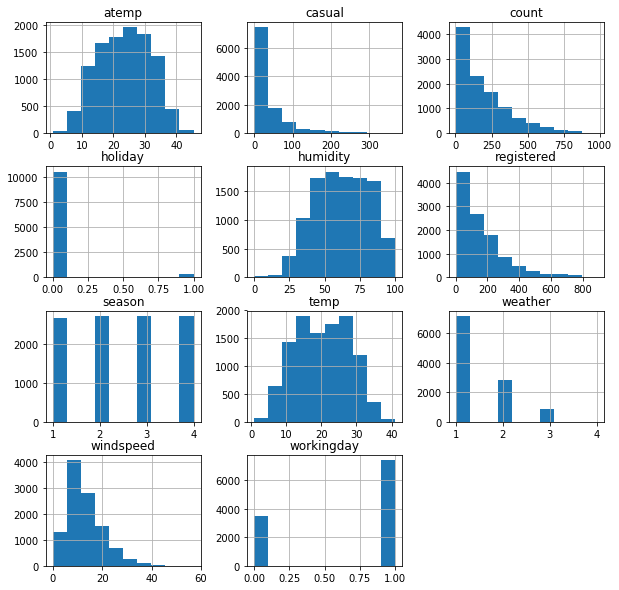

In [34]:
dataset.hist()
plt.show()

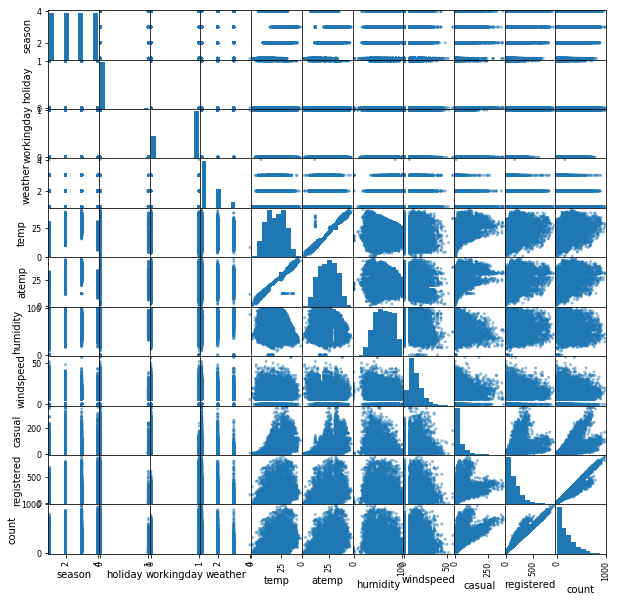

In [36]:
pd.plotting.scatter_matrix(dataset)
plt.show()